# Middleware

Middleware provides a way to more tightly control what happens inside the agent. Middleware is useful for the following:

1. Tracking agent behavior with logging, analytics and debugging.
2. Tranforming prompts, tool selection, and output formatting.
3. Adding retries, fallbacks, and early termination logic.
4. Applying rate limits, guardrails, and PII detection.

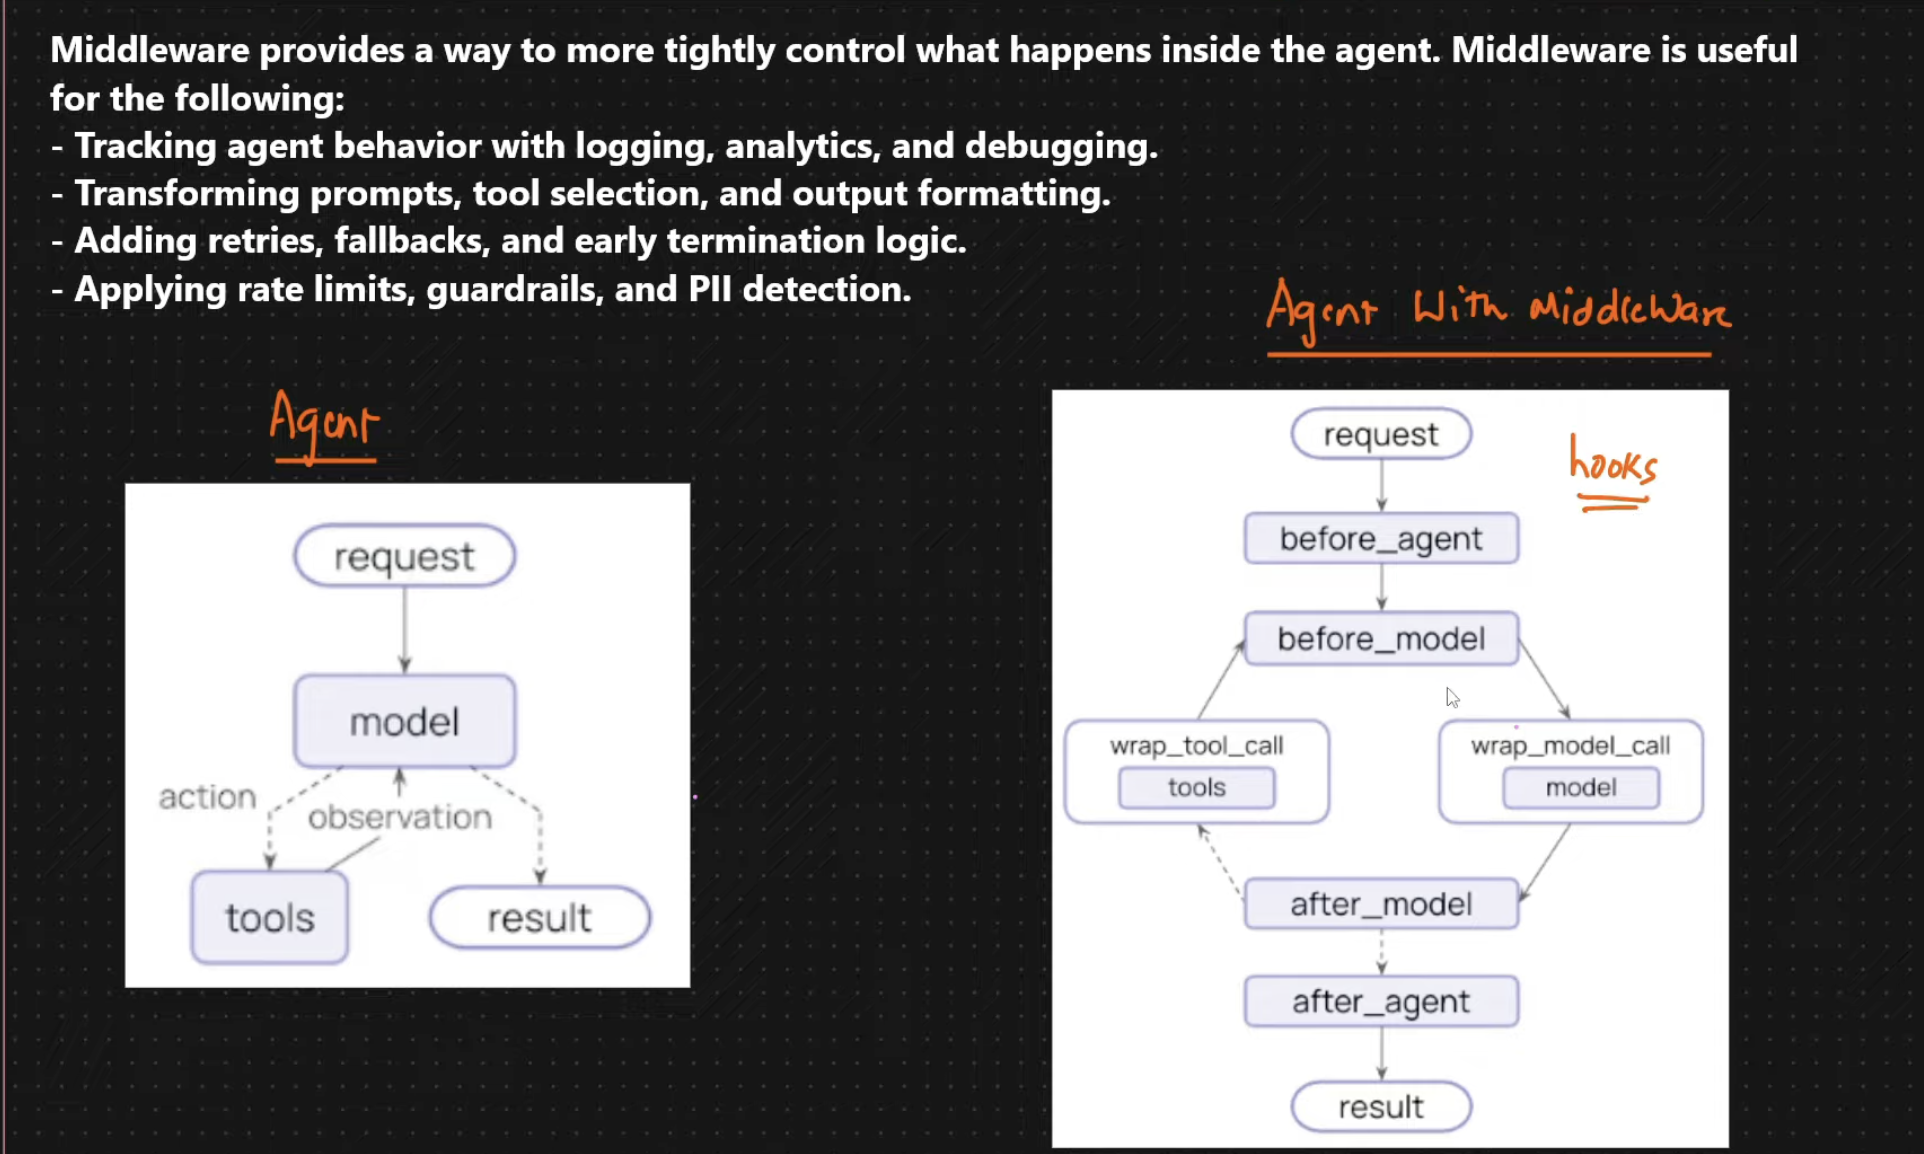

In [ ]:
import os


ishurawat2024

os.environ["OPENAI_API_KEY"] = ""

## Summarization Middleware

It is a middleware that can be added to the agent that automatically summarize conversation history when approaching token limit, preserving recent messages while compressing older context. Summarization is done using the same model as the agent. It is useful for agents that need to maintain a long conversation history, but don't want to run into token limits. It is useful for following:

1. Long running conversations that exceeds token limit.
2. Applications where preserving full conversation context matters.

 

In [4]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, SystemMessage


agent = create_agent(
    model="gpt-4o-mini",
    checkpointer=InMemorySaver(),
    middleware=[SummarizationMiddleware(
        model="gpt-4o-mini",
        trigger=("messages", 10),
        keep=("messages", 5),
        system_prompt="You are a helpful assistant."
    ) #add any number of middleware
    ]
)


In [5]:
config = {"configurable":{"thread_id":"test_-1"}}

In [8]:
questions = [
"What is the 2*2?",
"What is the largest planet in the solar system?",
"What is the chemical symbol for water?",
"What is the largest mammal on Earth?",
"What is the 100/4?",
"What is the currency of Japan?",
"What is the tallest mammal?",
"What is the chemical symbol for gold?",
"What is the largest desert in the world?",
"What is the smallest mammal?"
]

for q in questions:
    response = agent.invoke({"messages": [HumanMessage(content=q)]},config)
    print(f"messages: {response}")
    print(f"Messages: {len(response['messages'])}")

messages: {'messages': [HumanMessage(content='What is the 2*2?', additional_kwargs={}, response_metadata={}, id='66873c2a-e119-4369-98f2-518ed51d3908'), AIMessage(content='2 multiplied by 2 equals 4.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 15, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-CrFmpv7N8FR1pI9QvfTAYo26zcvdp', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b5df8-2138-7432-ab20-4d73ed4bc0ef-0', usage_metadata={'input_tokens': 15, 'output_tokens': 9, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasonin

## Summarization based on Token Size

In [10]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver 

In [21]:
@tool
def search_hotels(city:str) -> str:
    """Search hotels in a given city - returns long response to use more tokens"""
    return f"Searching hotels in {city}:\n\n1. Grand Hotel - 5 star, $350/night, spa, pool, gym\n2. City Inn - 4 star, $250/night, business center, gym\n3. Holiday Inn - 3 star, $150/night, free wifi"

agent = create_agent(
    model="gpt-4o-mini",
    tools=[search_hotels],
    checkpointer= InMemorySaver(),
    middleware=[ SummarizationMiddleware(
        model="gpt-4o-mini",
        trigger=("tokens", 550),
        keep=("tokens", 200),
    ),
    ])

config = {"configurable": {"thread_id": "test-1"}}

# token counter
def count_tokens(messages):
    total_chars = sum(len(str(msg.content)) for msg in messages)
    return {"tokens": total_chars//4}

In [23]:
# Run test

cities = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix"]

for city in cities:
    response = agent.invoke(
        {"messages": [{"role": "user", "content": f"Find hotels in {city}?"}]},
        config=config
    )

    tokens = count_tokens(response["messages"])
    print(f"{city}: ~{tokens} tokens, {len(response['messages'])} messages")
    print(response['messages'])


New York: ~{'tokens': 470} tokens, 5 messages
[HumanMessage(content='Here is a summary of the conversation to date:\n\nThe user inquired about hotels in New York, Los Angeles, Chicago, and Houston, with the AI providing options for each city, including hotel names, star ratings, prices per night, and amenities. The hotels listed were:\n\n- **New York**: \n  1. Grand Hotel: 5 stars, $350/night, amenities: Spa, pool, gym\n  2. City Inn: 4 stars, $250/night, amenities: Business center, gym\n  3. Holiday Inn: 3 stars, $150/night, amenities: Free Wi-Fi\n\n- **Los Angeles**: \n  1. Grand Hotel: 5 stars, $350/night, amenities: Spa, pool, gym\n  2. City Inn: 4 stars, $250/night, amenities: Business center, gym\n  3. Holiday Inn: 3 stars, $150/night, amenities: Free Wi-Fi\n\n- **Chicago**: \n  1. Grand Hotel: 5 stars, $350/night, amenities: Spa, pool, gym\n  2. City Inn: 4 stars, $250/night, amenities: Business center, gym\n  3. Holiday Inn: 3 stars, $150/night, amenities: Free Wi-Fi\n\n- **Hou

- Based on Fraction
- Model Fallback (fallback to another model if the first model fails)
- Tool Call limit and many more built-in middleware

## Human in the loop Middleware

For a critical or high stake task, you might want to ask for human feedback. 

In [27]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver


def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by id."""
    return f"Email content for id {email_id}"
    
def send_email_tool(recipient: str, content: str, subject: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject {subject} and content {content}"

In [29]:
agent = create_agent(
    model="gpt-4o-mini",
    tools=[read_email_tool, send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on = {
                "send_email_tool": {
                    "allowed_decisions":["approve", "edit", "reject"]
                },
                "read_mail_tool": False,
            }
        )
    ]
)
    

In [31]:
config = {"configurable": {"thread_id": "test-approve"}}

#Step 1: Request
result = agent.invoke({
    "messages": [HumanMessage("SEND email to johndoe@example.com with subject: Meeting Reminder and content: Meeting is scheduled for tomorrow at 10 AM.")]
},
config=config)

In [ ]:
result #need to take an approval from human being

{'messages': [HumanMessage(content='SEND email to johndoe@example.com with subject: Meeting Reminder and content: Meeting is scheduled for tomorrow at 10 AM.', additional_kwargs={}, response_metadata={}, id='f0b3ac9b-edcc-4a83-829b-db26599cca20'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 104, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-CrGWdHZhumr0xf5VUHqAPBJ0g6OR6', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b5e23-7849-7232-aa2b-9e55b952c13d-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recipient': 'johndoe@example.com', 'content': '

### Human Intervention is required

In [35]:
# Step 2: Approve
from langgraph.types import Command
if "__interrupt__" in result:
    print(" || Paused! Approving...")

    result = agent.invoke(
        Command (
            resume={
                "decisions":[
                    {
                        "type": "approve"
                    }
                ]
            }
        ),
        config=config
    )

    print(f"Result: {result['messages'][-1].content}")

 || Paused! Approving...
Result: The email has been sent to johndoe@example.com with the subject "Meeting Reminder" and the content stating that the meeting is scheduled for tomorrow at 10 AM.


In [ ]:
#What if human wants to reject it?
